Submission 3 By
$$Krish Bansal$$
$$23115069$$
(Starting part is from old submission)

__If You are running the whole notebook it may take some as experimenting part is very computationally heavy , sorry for not using Cuda as my laptop didn't supported that__

In [60]:
# Neccessary Imports

import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import scipy
import math
import seaborn as sns

### **Newton's Law of Cooling**
   This describes the rate of cooling of an object in a surrounding medium with constant temperature:
   $$
   \frac{dT}{dt} = -k(T - T_{\text{env}})
   $$
   where \(T(t)\) is the temperature of the object at time t, $T_{\text{env}}$ is the surrounding temperature, and \(k\) is a constant.

   **Solution**:
   $$
   T(t) = T_{\text{env}} + (T_0 - T_{\text{env}})e^{-kt}
   $$
   where $T_0$ is the initial temperature of the object.

   I have taken k = 3 and $T_0$ = 0 and $T_{\text{env}}$ = 1 for consistency

In [61]:
k = 3

# Defining Function to calculate dataset as the Solution of the equation exists

def lawofcooling(t0,tenv,t):
    x = tenv + (t0-tenv) * (torch.exp(-k*t))
    return x


In [62]:
testsize = 5

#train data which is equally spaced test size number of points between 0,2.5

t0 = torch.zeros(testsize,dtype=torch.float32)
tenv = torch.ones(testsize,dtype=torch.float32)
xtrain = torch.linspace(0,2.5,testsize,dtype=torch.float32)
ytrain = lawofcooling(t0,tenv,xtrain).view(-1,1)   # .view(-1,1) to convert it to coloum vector rather than row vector



#actual correct data for plotting at End

xactual = torch.linspace(0,5,500,dtype=torch.float32)
t0a = torch.zeros(500,dtype=torch.float32)
tenva = torch.ones(500,dtype=torch.float32)
yactual = lawofcooling(t0a,tenva,xactual)


In [63]:
#difining a neural network for later uses 

class network(nn.Module):
    
    def __init__(self,n_input,n_output,n_hidden,n_layers):
        super().__init__()
        
        # defining all these for use in forward pass 
        
        self.activation = nn.functional.relu   # Relu always works
        self.layers = n_layers
        self.f1 = nn.Linear(n_input,n_hidden)
        self.f2 = nn.Linear(n_hidden,n_hidden)
        self.f3 = nn.Linear(n_hidden,n_output)
        
    def forward(self,x):
        # forward pass
        
        x = self.f1(x)
        x = self.activation(x)
        for i in range (self.layers-1):
            x = self.f2(x)
            x = self.activation(x)
        x = self.f3(x)
        
        return x
        

In [67]:
model = network(1,1,32,3)                                  # defing a neural net with one input and on output and 32 layers each having 3 neurons

l_r= 0.001                                                 # tried many learning rates found this one working best

optimiser = torch.optim.Adam(model.parameters(),l_r)       # Adam is best as it is inbuilt whynot to use it

criteria =  torch.nn.functional.mse_loss                   # Standard Mean squraed loss 

In [68]:
epochs = 1000 # number of iterations 

print(f"loss at {0}th iteration is {loss.item()}")

for i in range(epochs):
    
    #forwad pass
    y_pred = model(xtrain.view(-1,1)).view(-1,1)
    loss = criteria(y_pred,ytrain)
    
    # backward pass
    loss.backward()
    optimiser.step()
    
    # resetting gradients
    optimiser.zero_grad()
    
    if(i%100 == 299):
        print(f"loss at {i+1}th iteration is {loss.item()}")
    

loss at 0th iteration is 7.542073909849734e-11
loss at 300th iteration is 9.474939361098222e-06
loss at 600th iteration is 9.473185855313204e-06
loss at 900th iteration is 9.473185855313204e-06


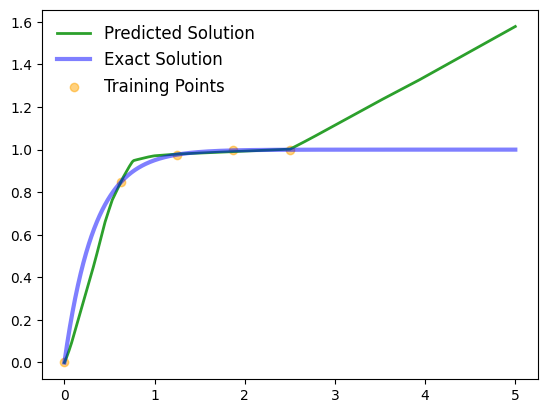

In [69]:
# Visualising Results with Graph

y_pred = model(xactual.view(-1,1)).detach()   # .detach() to stop gradient tracking by pytorch as Matplot can't plot those tensors

plt.plot(xactual,y_pred,color="tab:green",label = "Predicted Solution", linewidth=2)
plt.plot(xactual,yactual,"blue",label = "Exact Solution",alpha = 0.5, linewidth=3)
plt.scatter(xtrain,ytrain,label ="Training Points",alpha = 0.5,color="orange")
plt.legend(frameon=False, fontsize="large")
plt.show()


As You can see the predicions are not as accurate it should despite of 1000 iterations , increasing them might make it litlle more accurate but still the error which is after the value 2.5 can't be Solved this way thats why I will use PINN in next submission to solve this issue

<h1>NOW PINNS

The idea of a PINN(physics informed neural network) is adding a loss component of the differnential equation(which is basically the value of the differential equation) to the normal loss so that model trains on the physics behind it 

In [111]:
phy_size = 10  # data size for the physics points im taking
xphy = torch.linspace(0,5,phy_size,requires_grad = True).view(-1,1) # initialzing the x's of data
tenv = torch.ones(phy_size,dtype=torch.float32)

In [112]:
model = network(1,1,36,3)  # model initially with random size will experiment with size of it in later part
l_r= 0.006 # learning rate , will experiment with this too later
optimiser = torch.optim.Adam(model.parameters(),l_r) # again the same adam optimiser 
criteria =  torch.nn.functional.mse_loss # mean squared error for Loss

In [113]:
epochs =1

for i in range(epochs):
    y_pred = model(xtrain.view(-1,1)).view(-1,1)
    
    loss1 = criteria(y_pred,ytrain)
    
    yphy= model(xphy)
    dt = torch.autograd.grad(yphy,xphy,torch.ones_like(yphy))[0]
    
    var = dt + k*(xphy-tenv.view(-1,1))
    loss2 = torch.mean(var**2)
    print(f"loss by sample points {loss1.item()}")
    print(f"loss by differntial equation {loss2.item()}")
    

loss by sample points 0.5792695879936218
loss by differntial equation 43.33555603027344


As u can see the loss by sample points is very less as compared to loss with differential equation so minimizing this directly will not give better results due to vast equality in there values. So, i m adding a factor of 0.005 to physics loss to make it comparable with other loss

In [114]:
epochs =10000  # Number of iterations

for i in range(epochs):
    # Forward pass
    y_pred = model(xtrain.view(-1,1)).view(-1,1)
    
    loss1 = criteria(y_pred,ytrain)
    
    yphy= model(xphy)
    dt = torch.autograd.grad(yphy,xphy,torch.ones_like(yphy))[0] # calculating dy/dx using autograd to put in differential equation
    
    var = dt + k*(xphy-tenv) 
    loss2 =(0.005)*torch.mean(var**2) # the factor i talked about earlier
    #loss due to physics is basically the value of the differential equation
    

    loss = loss1 + loss2  # total loss is the sum of both the loss
    
    # backward pass
    
    loss.backward()
    
    optimiser.step()
    optimiser.zero_grad()
    if(i%2000 == 0):
        print(f"loss at {i+1}th iteration is {loss.item()}")

l_final = criteria(model(xactual.view(-1,1)),yactual.view(-1,1))
print() 
print(f"Final loss is {l_final}")

loss at 1th iteration is 0.7959473729133606
loss at 2001th iteration is 0.2131643295288086
loss at 4001th iteration is 0.2131643295288086
loss at 6001th iteration is 0.2131643295288086
loss at 8001th iteration is 0.2131643295288086

Final loss is 0.0013460355112329125


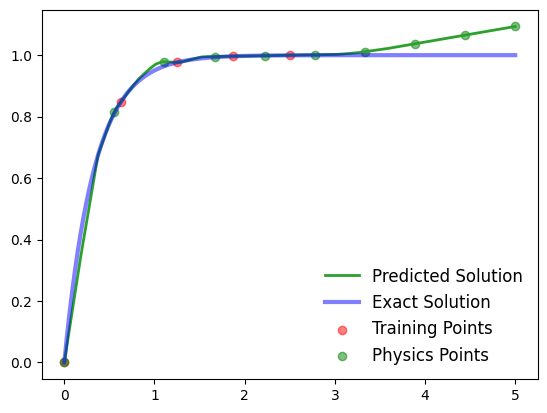

In [115]:
# plotiing as same as last time
y_pred = model(xactual.view(-1,1)).detach()
plt.plot(xactual,y_pred,color="tab:green",label = "Predicted Solution", linewidth=2)
plt.plot(xactual,yactual,"blue",label = "Exact Solution",alpha = 0.5, linewidth=3)
plt.scatter(xtrain,ytrain,label ="Training Points",alpha = 0.5,color="red")
plt.scatter(xphy.detach().numpy() ,yphy.detach().numpy() ,label ="Physics Points",alpha = 0.5,color="green")
plt.legend(frameon=False, fontsize="large")
plt.show()


As We can see its pretty acurate enough already but Will change the parameter by Experimenting them and try to make it more accurate

<h1>Now Experimenting

__First The learning rate__

In [15]:
learingratedata = np.zeros(20)

In [94]:
for j in range (1,21): # looping over learining rate from 0.001 to 0.02
    
    # The same thing as did above
    #.............................................................................
    xphy = torch.linspace(0,5,10,requires_grad = True).view(-1,1)
    tenv = torch.ones(10,dtype=torch.float32).view(-1,1)
    model = network(1,1,33,3)
    
    l_r= j*0.001
    optimiser = torch.optim.Adam(model.parameters(),l_r)
    criteria =  torch.nn.functional.mse_loss 
    epochs =10000

    for it in range(epochs):
        y_pred = model(xtrain.view(-1,1)).view(-1,1)
        
        loss1 = criteria(y_pred,ytrain)
        
        yphy= model(xphy)
        dt = torch.autograd.grad(yphy,xphy,torch.ones_like(yphy))[0]
        
        var = dt + k*(xphy-tenv)
        loss2 =(0.005)*torch.mean(var**2)
        
    
        loss = loss1 + loss2;
        
        loss.backward()
        
        optimiser.step()
        optimiser.zero_grad()
    
    loss_final = criteria(model(xactual.view(-1,1)),yactual.view(-1,1)).item()
    #...............................................................................
    
    learingratedata[j-1] = loss_final # storing the final loss to plot later



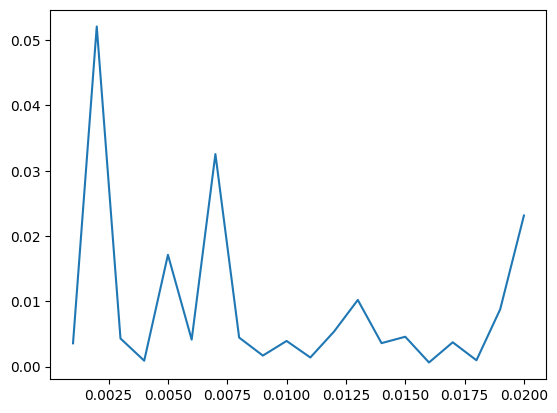

In [95]:
plt.plot([i * 0.001 for i in range(1,21)],learingratedata) # plotting the final data 

As I got minimum loss at learning rate =0.016 will use that now later

__Now the parameters of my model which are number of layer in model and number of neurons in one layer__

In [34]:
plotdata = np.zeros((10,10)) # 2d array for storing

In [96]:
for i in range(30,40): # i is number of layers
    for j in range (0,10): # j is nurons in one layer
        
        # iterating over different i,j for getting loss at each of it
        #...............................................................................
        xphy = torch.linspace(0,5,10,requires_grad = True).view(-1,1)
        tenv = torch.ones(10,dtype=torch.float32).view(-1,1)
        model = network(1,1,i,j)
        
        l_r= 0.016
        optimiser = torch.optim.Adam(model.parameters(),l_r)
        criteria =  torch.nn.functional.mse_loss 
        epochs =1000

        for it in range(epochs):
            y_pred = model(xtrain.view(-1,1)).view(-1,1)
            
            loss1 = criteria(y_pred,ytrain)
            
            yphy= model(xphy)
            dt = torch.autograd.grad(yphy,xphy,torch.ones_like(yphy))[0]
            
            var = dt + k*(xphy-tenv)
            loss2 =(0.005)*torch.mean(var**2)
            
        
            loss = loss1 + loss2;
            
            loss.backward()
            
            optimiser.step()
            optimiser.zero_grad()
        
        l_final = criteria(model(xactual.view(-1,1)),yactual.view(-1,1)).item()
        #....................................................................................
        
        plotdata[i-30][j] = l_final    # storing the final loss



In [97]:
for i in range(0,10):
    for j in range(0,10):
        plotdata[i][j]=plotdata[i][j]*(1e3) # for better looking plot

<Axes: >

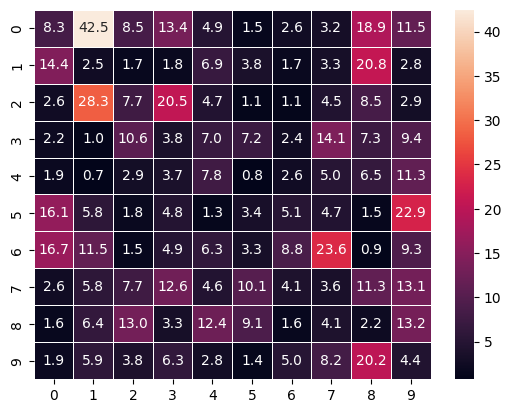

In [98]:
sns.heatmap(plotdata,fmt=".1f", annot=True, linewidths=0.5) # plotting the heatmap

As i Got minimum value at number of layers = 31 and number of neurons = 4 will use that now

<h1>Final Result with Best Parameters

In [99]:
xphy = torch.linspace(0,5,10,requires_grad = True).view(-1,1)
tenv = torch.ones(10,dtype=torch.float32).view(-1,1)
model = network(1,1,31,4)

l_r= 0.016
optimiser = torch.optim.Adam(model.parameters(),l_r)
criteria =  torch.nn.functional.mse_loss 

epochs =30000

for it in range(epochs):
    y_pred = model(xtrain.view(-1,1)).view(-1,1)
    
    loss1 = criteria(y_pred,ytrain)
    
    yphy= model(xphy)
    dt = torch.autograd.grad(yphy,xphy,torch.ones_like(yphy))[0]
    
    var = dt + k*(xphy-tenv)
    loss2 =(0.005)*torch.mean(var**2)
    

    loss = loss1 + loss2;
    
    loss.backward()
    
    optimiser.step()
    optimiser.zero_grad()
    if(it%3000 == 0):
        print(f"loss at {it+1}th iteration is {loss.item()}")

loss_final = criteria(model(xactual.view(-1,1)),yactual.view(-1,1)).item()

loss at 1th iteration is 0.7422677874565125
loss at 3001th iteration is 0.21447548270225525
loss at 6001th iteration is 0.21459265053272247
loss at 9001th iteration is 0.2122655063867569
loss at 12001th iteration is 0.2128623127937317
loss at 15001th iteration is 0.2133679836988449
loss at 18001th iteration is 0.2135048657655716
loss at 21001th iteration is 0.21436133980751038
loss at 24001th iteration is 0.21452155709266663
loss at 27001th iteration is 0.21460463106632233


In [100]:
print(loss_final)

0.005596547853201628


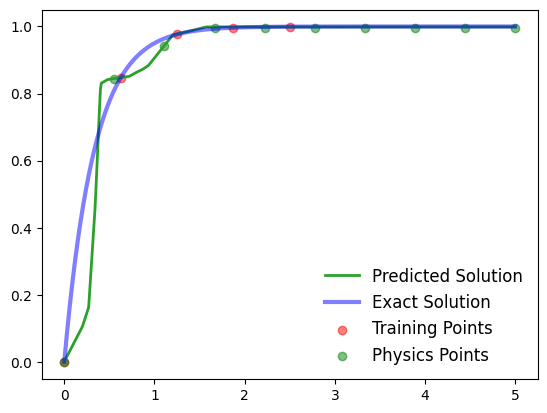

In [101]:
y_pred = model(xactual.view(-1,1)).detach()
plt.plot(xactual,y_pred,color="tab:green",label = "Predicted Solution", linewidth=2)
plt.plot(xactual,yactual,"blue",label = "Exact Solution",alpha = 0.5, linewidth=3)
plt.scatter(xtrain,ytrain,label ="Training Points",alpha = 0.5,color="red")
plt.scatter(xphy.detach().numpy() ,yphy.detach().numpy() ,label ="Physics Points",alpha = 0.5,color="green")
plt.legend(frameon=False, fontsize="large")
plt.show()


As We can see the parameter change does not cause a much big differnce so It might be not that important

__The difference between accuarcy the PINN and a normal neural net is easly visible via the graphs especially after the value where we didn't had training point (2.5)__